<a href="https://colab.research.google.com/github/costpetrides/Brain-Tumor-Classification/blob/main/CNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow gpu opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement gpu (from versions: none)
ERROR: No matching distribution found for gpu


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#To avoid out-of-memory (OOM) errors :)

#gpus = tf. config.experimental.list_physical_devices ('GPU')
#for gpu in gpus:
  #tf.config.experimental.set_memory_growth (gpu, True)

In [4]:
train_df = '/content/drive/MyDrive/DATA/BrainTumor/Training/' #training data
test_df = '/content/drive/MyDrive/DATA/BrainTumor/Testing/' #testing data

In [6]:
# collect file names and labels for dataset

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DATA/BrainTumor/Training'):
    for filename in filenames:
        pass

#a list for training labels
training_labels = []

for label in os.listdir(train_df):
    for image in os.listdir(train_df + label):
        training_labels.append(label)

#a list for testing labels
testing_labels = []

for label in os.listdir(test_df):
    for image in os.listdir(test_df + label):
        testing_labels.append(label)

In [7]:
training_labels_series = pd.Series(training_labels)  #converting the list into a serires !
training_labels_series.value_counts()

notumor       1605
pituitary     1457
meningioma    1339
glioma        1321
dtype: int64

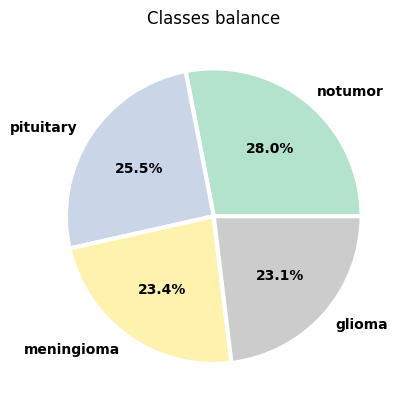

In [8]:
training_labels_series.value_counts().plot.pie(autopct='%.1f%%', cmap = 'Pastel2', textprops={'weight':'bold'}, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }).set_title("Classes balance")
plt.show()

In [9]:
def show_images(rows, columns, data):
    plt.figure(figsize=(columns*2.25, rows*2.25))
    for images, labels in data.take(1):
        for i in range(rows * columns):
            ax = plt.subplot(rows, columns, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off') # Turn off axis labels and ticks
            plt.title(data.class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

In [10]:
batch_size = 32
image_size = (180, 180)
training_data = tf.keras.utils.image_dataset_from_directory(train_df, validation_split=0.2, subset="training",seed=123, image_size = image_size, batch_size=batch_size)

Found 5722 files belonging to 4 classes.
Using 4578 files for training.


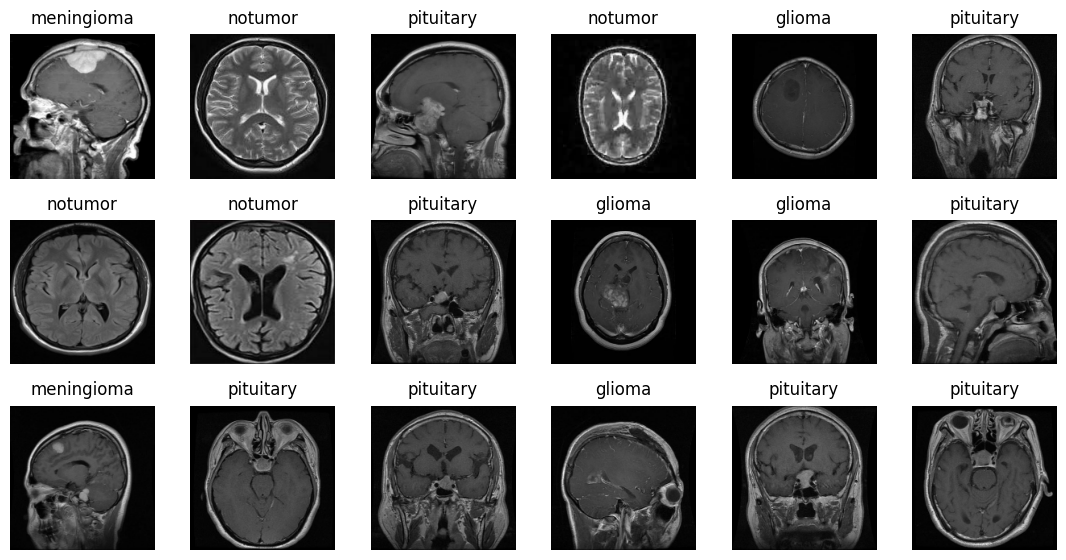

In [11]:
show_images(3, 6, training_data)   # Plot a sample of training dataset

In [13]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomRotation(10),          # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(                   # Normalize pixel values
        mean=[0.485, 0.456, 0.406],         # Mean values for each color channel
        std=[0.229, 0.224, 0.225]           # Standard deviation values for each color channel
    )
])

In [14]:
# Checking  if the images have file extensions that are not in the images_ext list and also handles any issues with reading the images!

import cv2
import imghdr

images_ext=['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(train_df):
  for image in os.listdir(os.path.join (train_df, image_class)):
    image_path = os.path.join(train_df, image_class,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what (image_path)
      if tip not in images_ext:
        print ('Image not in ext list (}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Issue with image /content/drive/MyDrive/DATA/BrainTumor/Training/notumor/Tr-no_1001.jpg


In [17]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize  to 224x224 pixels each image
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomRotation(10),          # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(                   # Normalize pixel values
        mean=[0.485, 0.456, 0.406],         # Mean values for each color channel
        std=[0.229, 0.224, 0.225]           # Standard deviation values for each color channel
    )
])

In [18]:
#Training dataset
train_dataset = ImageFolder(train_df, transform = data_transforms)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

train_dataset

Dataset ImageFolder
    Number of datapoints: 5722
    Root location: /content/drive/MyDrive/DATA/BrainTumor/Training/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
#Testing dataset
test_dataset = ImageFolder(test_df, transform = data_transforms)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

test_dataset

Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /content/drive/MyDrive/DATA/BrainTumor/Testing/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# OUR MODEL..:)



1. Input Layer:
  - It uses a 2D convolutional layer (Conv2D) with 32 filters, each of size (4, 4), and the ReLU activation function.
  - The input shape is defined by the image_shape, a 3-channel image (RGB) with dimensions image_size[0] x image_size[1].
  - A max-pooling layer with a pool size of (3, 3) follows the convolutional layer.

2. Hidden Layers:
  - Three additional Conv2D layers with 64, 128, and 128 filters, respectively. -  All use the ReLU activation function.
  - After each convolutional layer, there's a max-pooling layer with a pool size of (3, 3).
  - The last convolutional layer is followed by a Flatten layer, which converts the output into a one-dimensional array for passing to fully connected layers.

3.Fully Connected Layers:
  - A Dense (fully connected) layer with 512 units and ReLU activation.
  - A Dropout layer with a dropout rate of 0.5 and a seed of 111. Dropout is used to reduce overfitting by randomly deactivating neurons during training.
  - The final Dense layer has 4 units, which is suitable for a classification problem with 4 classes. It uses the softmax activation function, which is typical for multi-class classification problems.



In [21]:
model = models.Sequential()

# Input layer
image_shape = (image_size[0], image_size[1], 3)

model.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Hidden layers
model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten())

# Output layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed = 111))
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 177, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [22]:
model.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [23]:
#  data augmentation and preprocessing pipelines for training and testing data

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,                           # Allows random rotation of images by up to 10 degrees
                                   brightness_range=(0.85, 1.15),               # Randomly adjusts the brightness of images within the specified range
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,                            # Applies random shearing transformations
                                   zoom_range=0,                                # No zooming applied
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data !
train_generator = train_datagen.flow_from_directory(train_df,
                                                    target_size=image_size,     # Specifies the dimensions to which the images are resized
                                                    batch_size=batch_size,      # Sets the number of images per batch
                                                    class_mode="categorical",
                                                    seed=111)                   # Seed for reproducibility

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data !
test_generator = test_datagen.flow_from_directory(test_df,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=111)

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [24]:
class_labels = train_generator.class_indices
print(class_labels)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
history = model.fit(train_generator,
                        steps_per_epoch = 100,   # Training data will be divided into 100 batches per epoch
                        epochs = 40,             # Number of times we want to iterate over the entire training dataset
                        validation_data = test_generator,
                        validation_steps = 40)   # Number of batches to use from the validation data during each validation epoch.

Epoch 1/40
100/100 [==============================] - 208s 2s/step - loss: 0.9738 - accuracy: 0.5476 - val_loss: 0.8583 - val_accuracy: 0.6938
Epoch 2/40
100/100 [==============================] - 196s 2s/step - loss: 0.6162 - accuracy: 0.7509 - val_loss: 0.5704 - val_accuracy: 0.7563
Epoch 3/40
100/100 [==============================] - 225s 2s/step - loss: 0.5025 - accuracy: 0.7987 - val_loss: 0.5138 - val_accuracy: 0.7898
Epoch 4/40
100/100 [==============================] - 200s 2s/step - loss: 0.4483 - accuracy: 0.8225 - val_loss: 0.4300 - val_accuracy: 0.8055
Epoch 5/40
100/100 [==============================] - 200s 2s/step - loss: 0.3646 - accuracy: 0.8537 - val_loss: 0.4373 - val_accuracy: 0.8430
Epoch 6/40
100/100 [==============================] - 195s 2s/step - loss: 0.3203 - accuracy: 0.8775 - val_loss: 0.4663 - val_accuracy: 0.8344
Epoch 7/40
100/100 [==============================] - 193s 2s/step - loss: 0.2855 - accuracy: 0.8936 - val_loss: 0.3699 - val_accuracy: 0.8578

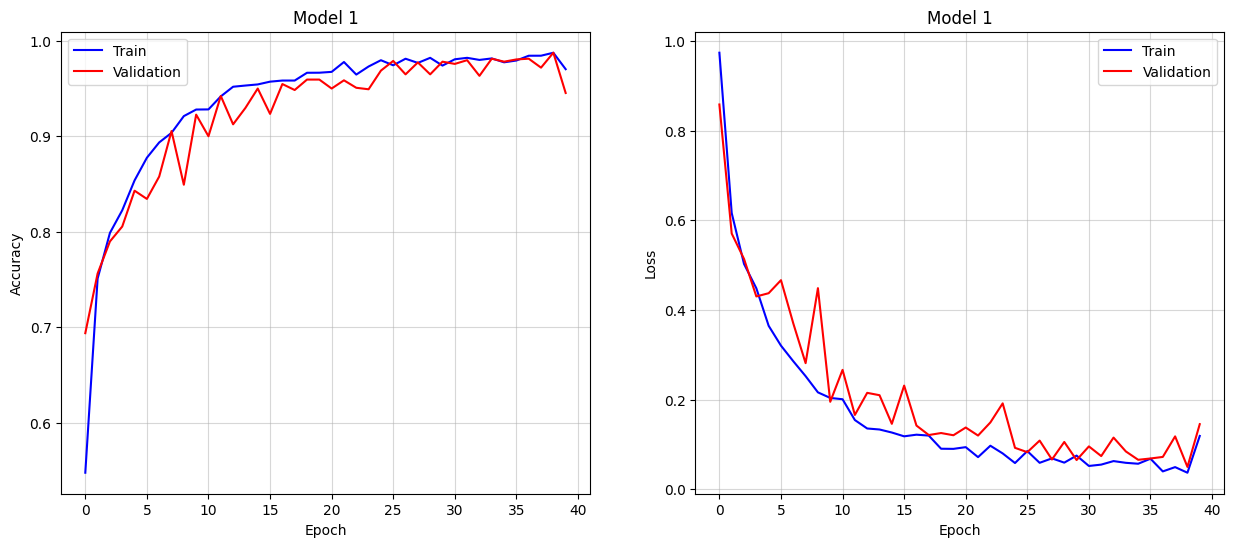

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], color='blue')
ax[0].plot(history.history['val_accuracy'], color='red')
ax[0].set_title('Model 1')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.5)

# Training and validation loss over epochs
ax[1].plot(history.history['loss'], color='blue')
ax[1].plot(history.history['val_loss'], color='red')
ax[1].set_title('Model 1')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.5)

plt.show()

In [ ]:
from tensorflow. keras.models import load_model

model.save (os.path.join('/content/drive/MyDrive/DATA', 'BrainTumor_1.h5'))
Brain_model_1 = load_model(os.path. join ('/content/drive/MyDrive/DATA', 'BrainTumor_1.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Our second model ...
**Model 2 (model2):**

1. Input Layer:
  -  Convolutional layer with 32 filters and a 4x4 kernel, ReLU activation, and 'same' padding.
2. Hidden Layers:
  - Five more pairs of convolutional and max-pooling layers with increasing filter sizes (64, 128, 128, 256). All convolutional layers use ReLU activation with 'same' padding.
3. Flatten Layer:
  - Flattens the output from the last convolutional layer.
4. Output Layer:
  - Two fully connected (Dense) layers. The first has 512 units with ReLU activation and a dropout layer with a 50% dropout rate. The final output layer has 4 units with softmax activation for 4 classes.

In [ ]:
model_2 = models.Sequential()

# input layer
model_2.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape, padding='same'))
model_2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

# hidden layers
model_2.add(Conv2D(64, (4, 4), activation="relu", padding='same'))
model_2.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model_2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model_2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model_2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model_2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model_2.add(Conv2D(256, (4, 4), activation="relu", padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_2.add(Flatten())

# output layer
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.5, seed = 111))
model_2.add(Dense(4, activation="softmax"))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 128)        

In [ ]:
model_2.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history_2 = model_2.fit(train_generator,
                        steps_per_epoch = 100,
                        epochs = 40,
                        validation_data = test_generator,
                        validation_steps = 40)

Epoch 1/40
100/100 [==============================] - 255s 3s/step - loss: 0.0982 - accuracy: 0.9662 - val_loss: 0.1148 - val_accuracy: 0.9703
Epoch 2/40
100/100 [==============================] - 243s 2s/step - loss: 0.0865 - accuracy: 0.9725 - val_loss: 0.0950 - val_accuracy: 0.9695
Epoch 3/40
100/100 [==============================] - 239s 2s/step - loss: 0.0939 - accuracy: 0.9643 - val_loss: 0.2285 - val_accuracy: 0.9438
Epoch 4/40
100/100 [==============================] - 238s 2s/step - loss: 0.0816 - accuracy: 0.9719 - val_loss: 0.0916 - val_accuracy: 0.9703
Epoch 5/40
100/100 [==============================] - 254s 3s/step - loss: 0.0745 - accuracy: 0.9775 - val_loss: 0.1097 - val_accuracy: 0.9734
Epoch 6/40
100/100 [==============================] - 237s 2s/step - loss: 0.0644 - accuracy: 0.9781 - val_loss: 0.1113 - val_accuracy: 0.9688
Epoch 7/40
100/100 [==============================] - 252s 3s/step - loss: 0.0812 - accuracy: 0.9694 - val_loss: 0.1837 - val_accuracy: 0.9438

# Differnces between Model_1 and Model_2

**Model Architecture:**

- "Model 1" uses a specific architecture with multiple convolutional layers and max-pooling layers, along with fully connected layers.
- "Model 2" also uses convolutional layers, max-pooling layers, and fully connected layers, but with different layer configurations and filter sizes.

**Model Compilation:**

- "Model 1" is compiled with an Adam optimizer with specific learning rates and beta values.
- "Model 2" is compiled with an Adam optimizer, but with different learning rates and beta values.

**Data Augmentation and Preprocessing:**

- "Model 1" applies data augmentation to the training data, including rotation, brightness adjustment, shifting, shear, and flipping.
- "Model 2" applies a different set of data augmentation techniques to the training data, including rotation, brightness adjustment, shifting, shear, and flipping.

**Data Loading:**

- "Model 1" loads training and test data using `flow_from_directory` with specific settings.
- "Model 2" also loads training and test data using `flow_from_directory` with similar settings, including a constant seed for reproducibility.

**Training:**

- Both "Model 1" and "Model 2" are trained for 40 epochs with a specific number of steps per epoch and validation steps.
- They use different training data generators (train_generator and test_generator), which have different data augmentation settings.



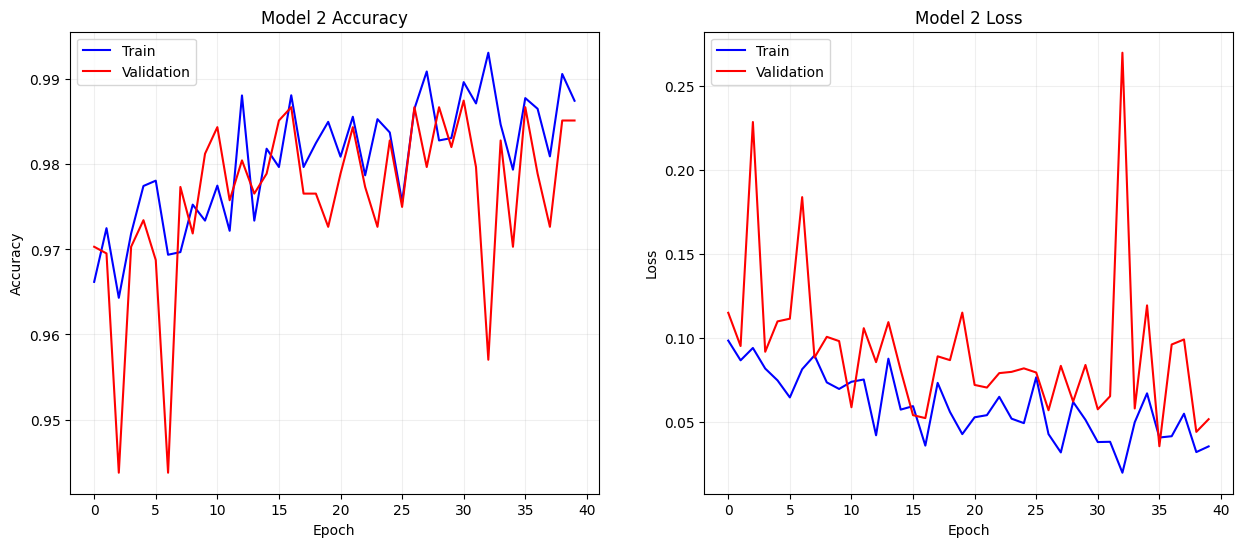

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(history_2.history['accuracy'], color='blue')
ax[0].plot(history_2.history['val_accuracy'], color='red')
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs for model2
ax[1].plot(history_2.history['loss'], color='blue')
ax[1].plot(history_2.history['val_loss'], color='red')
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

In [ ]:
from tensorflow. keras.models import load_model

model.save (os.path.join('/content/drive/MyDrive/DATA', 'BrainTumor_2.h5'))
Brain_model_1 = load_model(os.path. join ('/content/drive/MyDrive/DATA', 'BrainTumor_2.h5'))